In [1]:
#upload model file model.py
from google.colab import files
uploaded = files.upload()

Saving models.py to models.py


In [2]:
#installing all dependencies
!pip install torchattacks
!pip install torch==1.7.1 torchvision==0.8.2 
!pip install torch-dct


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 29.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 53.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
t

In [3]:
#importing all necessary libraries
import torch_dct as dct
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD, FGSM
from torchattacks import FFGSM

from models import CNN
import random
random.seed(42)

In [4]:
#Downloading Fashion MNIST Dataset

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

fashion_mnist_test = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

0it [00:00, ?it/s]

Extracting ./data1/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data1/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data1/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#loading the dataset with pytorch loaders
batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42)

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42)

In [25]:
#defining model and parameters
model = CNN().cuda()
model1 = CNN().cuda()
model2 = CNN().cuda()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 5
model

CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [7]:
#standard test function showing accuarcy (no attack)
def standard_test(model):
      model.eval()

      correct = 0
      total = 0

      for images, labels in test_loader:
          
          images = images.cuda()
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum()
          
      print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

In [8]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel

def test_attack(model,test_loader,attack="FGSM",dct_test=False):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          

          for images, labels in test_loader:
              
              if(dct_test==False):
                images = atk(images, labels).cuda()
              else:
                img =dct.dct1(images)
                images = atk(img, labels).cuda()
                images=dct.idct(images)

              
              outputs = model(images)
              
              _, predicted = torch.max(outputs.data, 1)
              
              total += labels.size(0)
              correct += (predicted == labels.cuda()).sum()
          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))

In [9]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel
#can also vary the percentage of adversarial examples .Default = 1 (100% attack)

def test_attack_percentage(model,test_loader,attack="FGSM",dct_test=False,percentage = 1):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          
          counter = 0
      

          for images, labels in test_loader:

              images, labels = images.cuda(), labels.cuda()
              
              if(counter < int(len(test_loader)*percentage)):    #int(len(test_loader))):

                if(dct_test==False):
                  images = atk(images, labels).cuda()
                else:
                  img =dct.dct1(images)
                  images = atk(img, labels).cuda()
                  images=dct.idct(images)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()

                counter +=1
              else:

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()
      

          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))
          print(len(test_loader))
          print(counter)

In [10]:
#train function with PGD attack and toggle between DCT and Pixel representation .Default is Pixel

def pgd_train(model,train_loader,optimizer,loss,dct_train=False,num_epochs=5):
    model.train()
    atk = PGD(model, eps=0.3, alpha=0.1, steps=7)
    print(type(atk))
    for epoch in range(num_epochs):

        total_batch = len(fashion_mnist_train) // batch_size
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):

           
            Y = batch_labels.cuda()

            if(dct_train==True):
              dct1 = dct.dct1(batch_images)
              X = atk(dct1, batch_labels).cuda()
              X=dct.idct(X)
            else:
              X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    return cost

In [11]:
#standard training with 0% adversarial examples
def standard_train(model,train_loader,optimizer,loss,num_epochs=5):
  model.train()
  for epoch in range(num_epochs):

      total_batch = len(fashion_mnist_train) // batch_size
      
      for i, (batch_images, batch_labels) in enumerate(train_loader):
          X = batch_images.cuda()
          Y = batch_labels.cuda()

          pre = model(X)
          cost = loss(pre, Y)

          optimizer.zero_grad()
          cost.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

cost0=standard_train(model,train_loader,optimizer,loss)
standard_test(model)

Epoch [1/5], lter [100/468], Loss: 0.8718
Epoch [1/5], lter [200/468], Loss: 0.5026
Epoch [1/5], lter [300/468], Loss: 0.5188
Epoch [1/5], lter [400/468], Loss: 0.5157
Epoch [2/5], lter [100/468], Loss: 0.5294
Epoch [2/5], lter [200/468], Loss: 0.4786
Epoch [2/5], lter [300/468], Loss: 0.4124
Epoch [2/5], lter [400/468], Loss: 0.4044
Epoch [3/5], lter [100/468], Loss: 0.2839
Epoch [3/5], lter [200/468], Loss: 0.3130
Epoch [3/5], lter [300/468], Loss: 0.2234
Epoch [3/5], lter [400/468], Loss: 0.3697
Epoch [4/5], lter [100/468], Loss: 0.3104
Epoch [4/5], lter [200/468], Loss: 0.2594
Epoch [4/5], lter [300/468], Loss: 0.2731
Epoch [4/5], lter [400/468], Loss: 0.2477
Epoch [5/5], lter [100/468], Loss: 0.1945
Epoch [5/5], lter [200/468], Loss: 0.3700
Epoch [5/5], lter [300/468], Loss: 0.2074
Epoch [5/5], lter [400/468], Loss: 0.1405
Standard accuracy: 89.59 %


In [12]:
test_attack(model,test_loader,"FGSM")
test_attack(model,test_loader,"PGD")
test_attack(model,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 0.15 %
TEST with PGD on Fashion MNIST
Robust accuracy : 0.00 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 22.23 %


In [26]:
#Initial training in Pixel representation
cost1=pgd_train(model1,train_loader,optimizer1,loss)
cost1

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/5], lter [100/468], Loss: 2.3051
Epoch [1/5], lter [200/468], Loss: 2.2114
Epoch [1/5], lter [300/468], Loss: 2.1192
Epoch [1/5], lter [400/468], Loss: 2.0000
Epoch [2/5], lter [100/468], Loss: 2.0371
Epoch [2/5], lter [200/468], Loss: 1.9415
Epoch [2/5], lter [300/468], Loss: 1.8792
Epoch [2/5], lter [400/468], Loss: 1.8069
Epoch [3/5], lter [100/468], Loss: 1.9089
Epoch [3/5], lter [200/468], Loss: 1.7058
Epoch [3/5], lter [300/468], Loss: 1.6102
Epoch [3/5], lter [400/468], Loss: 1.6854
Epoch [4/5], lter [100/468], Loss: 1.7056
Epoch [4/5], lter [200/468], Loss: 1.5893
Epoch [4/5], lter [300/468], Loss: 1.5250
Epoch [4/5], lter [400/468], Loss: 1.6276
Epoch [5/5], lter [100/468], Loss: 1.5847
Epoch [5/5], lter [200/468], Loss: 1.3991
Epoch [5/5], lter [300/468], Loss: 1.5085
Epoch [5/5], lter [400/468], Loss: 1.4200


tensor(1.3565, device='cuda:0', grad_fn=<NllLossBackward>)

In [15]:
#test accuracy without any attacks
standard_test(model1)

Standard accuracy: 59.52 %


In [27]:
#robustness accuracy after 3 adverserial attacks

test_attack(model1,test_loader,"FGSM")
test_attack(model1,test_loader,"PGD")
test_attack(model1,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 50.65 %
TEST with PGD on Fashion MNIST
Robust accuracy : 46.05 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 56.89 %


In [28]:

test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

TEST with PGD on Fashion MNIST
Robust accuracy : 10.27 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 10.35 %


In [18]:
test_attack_percentage(model1,test_loader,attack="PGD",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FGSM",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FFGSM",dct_test=False,percentage = .5)

TEST with PGD on Fashion MNIST
Robust accuracy : 51.85 %
79
39
TEST with FGSM on Fashion MNIST
Robust accuracy : 54.50 %
79
39
TEST with FFGSM on Fashion MNIST
Robust accuracy : 58.53 %
79
39


In [19]:
#retraining in PGD attack with DCT basis representation

cost2=pgd_train(model1,train_loader,optimizer1,loss,dct_train=True)
cost2

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/5], lter [100/468], Loss: 1.3013
Epoch [1/5], lter [200/468], Loss: 0.8687
Epoch [1/5], lter [300/468], Loss: 0.8458
Epoch [1/5], lter [400/468], Loss: 0.9025
Epoch [2/5], lter [100/468], Loss: 0.7015
Epoch [2/5], lter [200/468], Loss: 0.7904
Epoch [2/5], lter [300/468], Loss: 0.6129
Epoch [2/5], lter [400/468], Loss: 0.6155
Epoch [3/5], lter [100/468], Loss: 0.4038
Epoch [3/5], lter [200/468], Loss: 0.5579
Epoch [3/5], lter [300/468], Loss: 0.5655
Epoch [3/5], lter [400/468], Loss: 0.6823
Epoch [4/5], lter [100/468], Loss: 0.4597
Epoch [4/5], lter [200/468], Loss: 0.3894
Epoch [4/5], lter [300/468], Loss: 0.5188
Epoch [4/5], lter [400/468], Loss: 0.4221
Epoch [5/5], lter [100/468], Loss: 0.4843
Epoch [5/5], lter [200/468], Loss: 0.6671
Epoch [5/5], lter [300/468], Loss: 0.4440
Epoch [5/5], lter [400/468], Loss: 0.4765


tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward>)

In [20]:
#@title
#testing robustness after attacking in DCT representation 

test_attack(model1,test_loader,"FGSM",True)
test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

TEST with FGSM on Fashion MNIST
Robust accuracy : 80.15 %
TEST with PGD on Fashion MNIST
Robust accuracy : 82.26 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 77.30 %


In [21]:

test_attack(model1,test_loader,"FGSM",False)
test_attack(model1,test_loader,"PGD",False)
test_attack(model1,test_loader,"FFGSM",False)

TEST with FGSM on Fashion MNIST
Robust accuracy : 10.79 %
TEST with PGD on Fashion MNIST
Robust accuracy : 4.67 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 17.52 %


In [14]:
#Loss when converting from Pixel to DCT

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


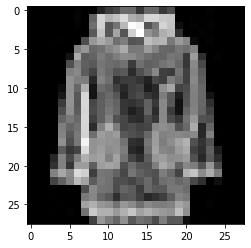

In [22]:
#Pixel representation
import matplotlib.pyplot as plt

fig = plt.figure()

plt.imshow(example_data[0][0], cmap='gray', interpolation='none')





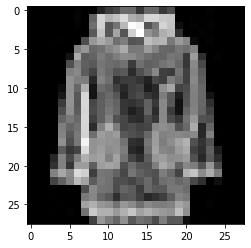

In [27]:
#DCT representation

fig1 = plt.figure()

plt.imshow(dct.idct(dct.dct(example_data[0][0])), cmap='gray', interpolation='none')



In [28]:
#MSE LOSS between the two tensors
input = example_data
target = dct.idct(dct.dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(input, target)


#print('input: ', input)
#print('target: ', target)
print('output: ', output)

output:  tensor(2.4476e-15)
